# Question 2

A data follows the following model for a time series:
- Use the notebook get GNP data.ipynb to get the data
- Use AR model on rgnp to predict the last 10 observations. 
    - Adjust the number of lags to consider using any model selection criteria you choose.
- Use VAR model (vector auto-regressive) to predict the last 10 observations of the data
- Replace the prediction models in the last two sections with corresponding LSTM models.
    - The LSTM models should be implemeted in PyTorch. 
    - You should optimize the hidden state size using validation set.
    
Hint: 
- For the regression model you may prefer to work on derivatives of the series. 
- You can check the order of derivation using Augmented Dickey-Fuller test.

In [1]:
import numpy as np
import pandas as pd

In [2]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
test_samples = 10
train_df = df[:-test_samples]
test_df = df[len(train_df):]
# print(df.shape)  # (123, 8)
df.tail()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


1. rgnp  : Real GNP.
2. pgnp  : Potential real GNP.
3. ulc   : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf   : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

## Using AR(p) model for rgnp

### Testing for stationarity

In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_df['rgnp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.081173
p-value: 0.964752


### rndp is not stationary - try fix using first derivative

In [93]:
rgnp_diff = train_df['rgnp'].diff().dropna()
# rgnp_diff = np.log(train_df['rgnp']).diff().dropna()
result = adfuller(rgnp_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.355104
p-value: 0.000004


#### Now it is stationary

### Find the number of required lags/AR terms (order of p)

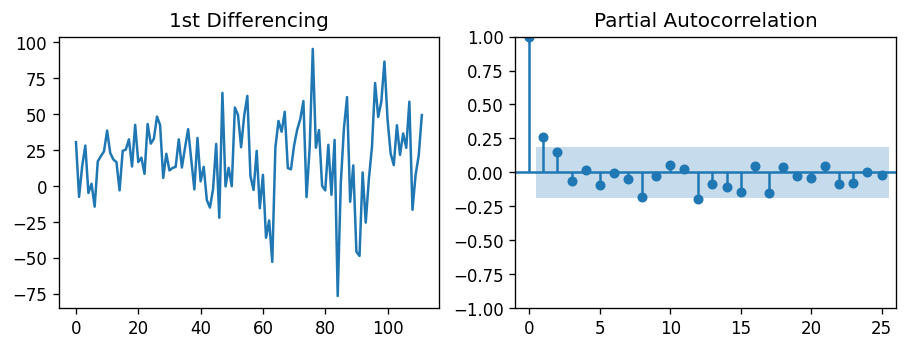

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(rgnp_diff.values); axes[0].set_title('1st Differencing')
axes[1].set(xlim=(-1 ,26))
plot_pacf(rgnp_diff.values, lags=25, method='ywm', ax = axes[1])

plt.show()

- PACF lag 1 is quite significant since is well above the significance line. 
- Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region)

### Instantiate and fit the AR model with training data

In [95]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(rgnp_diff, lags=2).fit()

# print(ar_model.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


### Plot the prediction vs test data

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


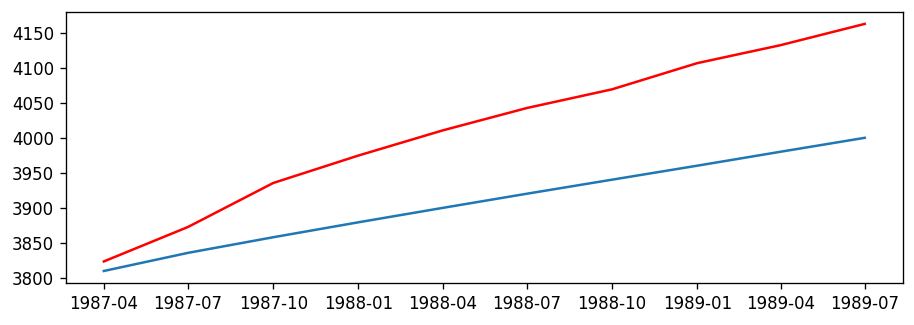

In [100]:
pred = ar_model.predict(start=test_df.index[0], end=test_df.index[-1], dynamic=False)
# invert derivative
pred = train_df['rgnp'][-1] + pred.cumsum()
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(test_df['rgnp'], color='red')

## Using VAR(p) model for the data

### Testing for stationarity

In [101]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [102]:
# ADF Test on each column
for name, column in train_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.0812
 No. Lags Chosen       = 2
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.9648. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.929
 No. Lags Chosen       = 1
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.9935. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. 

In [104]:
# 1st difference
df_differenced = train_df.diff().dropna()

In [106]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3551
 No. Lags Chosen       = 1
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9396
 No. Lags Chosen       = 0
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.3137. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signi

In [107]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [108]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7997
 No. Lags Chosen       = 2
 Critical value 1%     = -3.492
 Critical value 5%     = -2.889
 Critical value 10%    = -2.581
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6935
 No. Lags Chosen       = 0
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


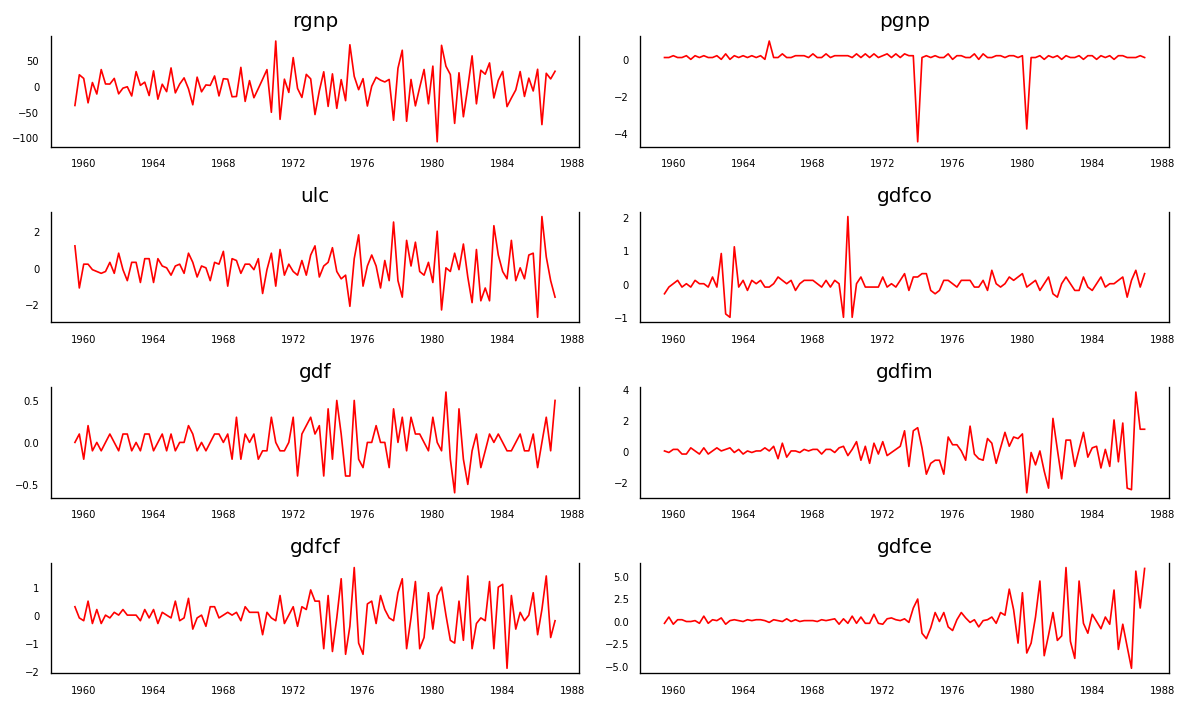

In [110]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_differenced[df_differenced.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Select the Order (P) of VAR model

In [115]:
from statsmodels.tsa.api import VAR

model = VAR(df_differenced)
x = model.select_order(maxlags=4)
x.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,-0.7630,-0.5631*,0.4663,-0.6820*
1,-1.374,0.4246,0.2539,-0.6448
2,-1.739,1.658,0.1795,-0.3621
3,-2.020,2.976,0.1424,0.005540
4,-2.316*,4.279,0.1165*,0.3575


#### All except FPE are lowest for lag=1

### Fit VAR(1) model

In [117]:
model_fitted = model.fit(1)
# model_fitted.summary()

In [121]:
# Get the lag order
lag_order = model_fitted.k_ar
# print(lag_order)  #> 1

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=test_samples)
df_forecast = pd.DataFrame(fc, index=test_df.index[0:], columns=test_df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1987-04-01,-21.194879,-0.277950,1.115520,-0.003529,-0.292582,-0.037051,-0.618566,-0.923536
1987-07-01,5.839737,-0.035350,-0.531200,-0.007137,0.112312,0.003211,0.316589,-0.263439
1987-10-01,2.924587,0.167931,0.163074,0.044702,-0.010615,-0.073666,-0.046881,0.110872
1988-01-01,-3.402745,0.043577,-0.002429,-0.015171,0.015923,0.113058,-0.009932,0.085255
1988-04-01,2.624176,0.085414,-0.017889,0.031621,0.001410,-0.004265,0.019792,-0.033985
1988-07-01,-0.943857,0.070535,0.012596,0.001383,0.015501,0.024449,-0.003605,0.045498
1988-10-01,0.815817,0.080136,0.003278,0.019244,0.004944,0.030788,0.010180,0.018497
1989-01-01,-0.032623,0.073127,0.000346,0.008838,0.011224,0.023153,0.000786,0.024179
1989-04-01,0.411694,0.077345,0.005124,0.015054,0.007875,0.025276,0.007790,0.022211


In [122]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [125]:
df_results = invert_transformation(train_df, df_forecast, second_diff=True)
df_forecast = df_results.filter(regex='_forecast$', axis=1)

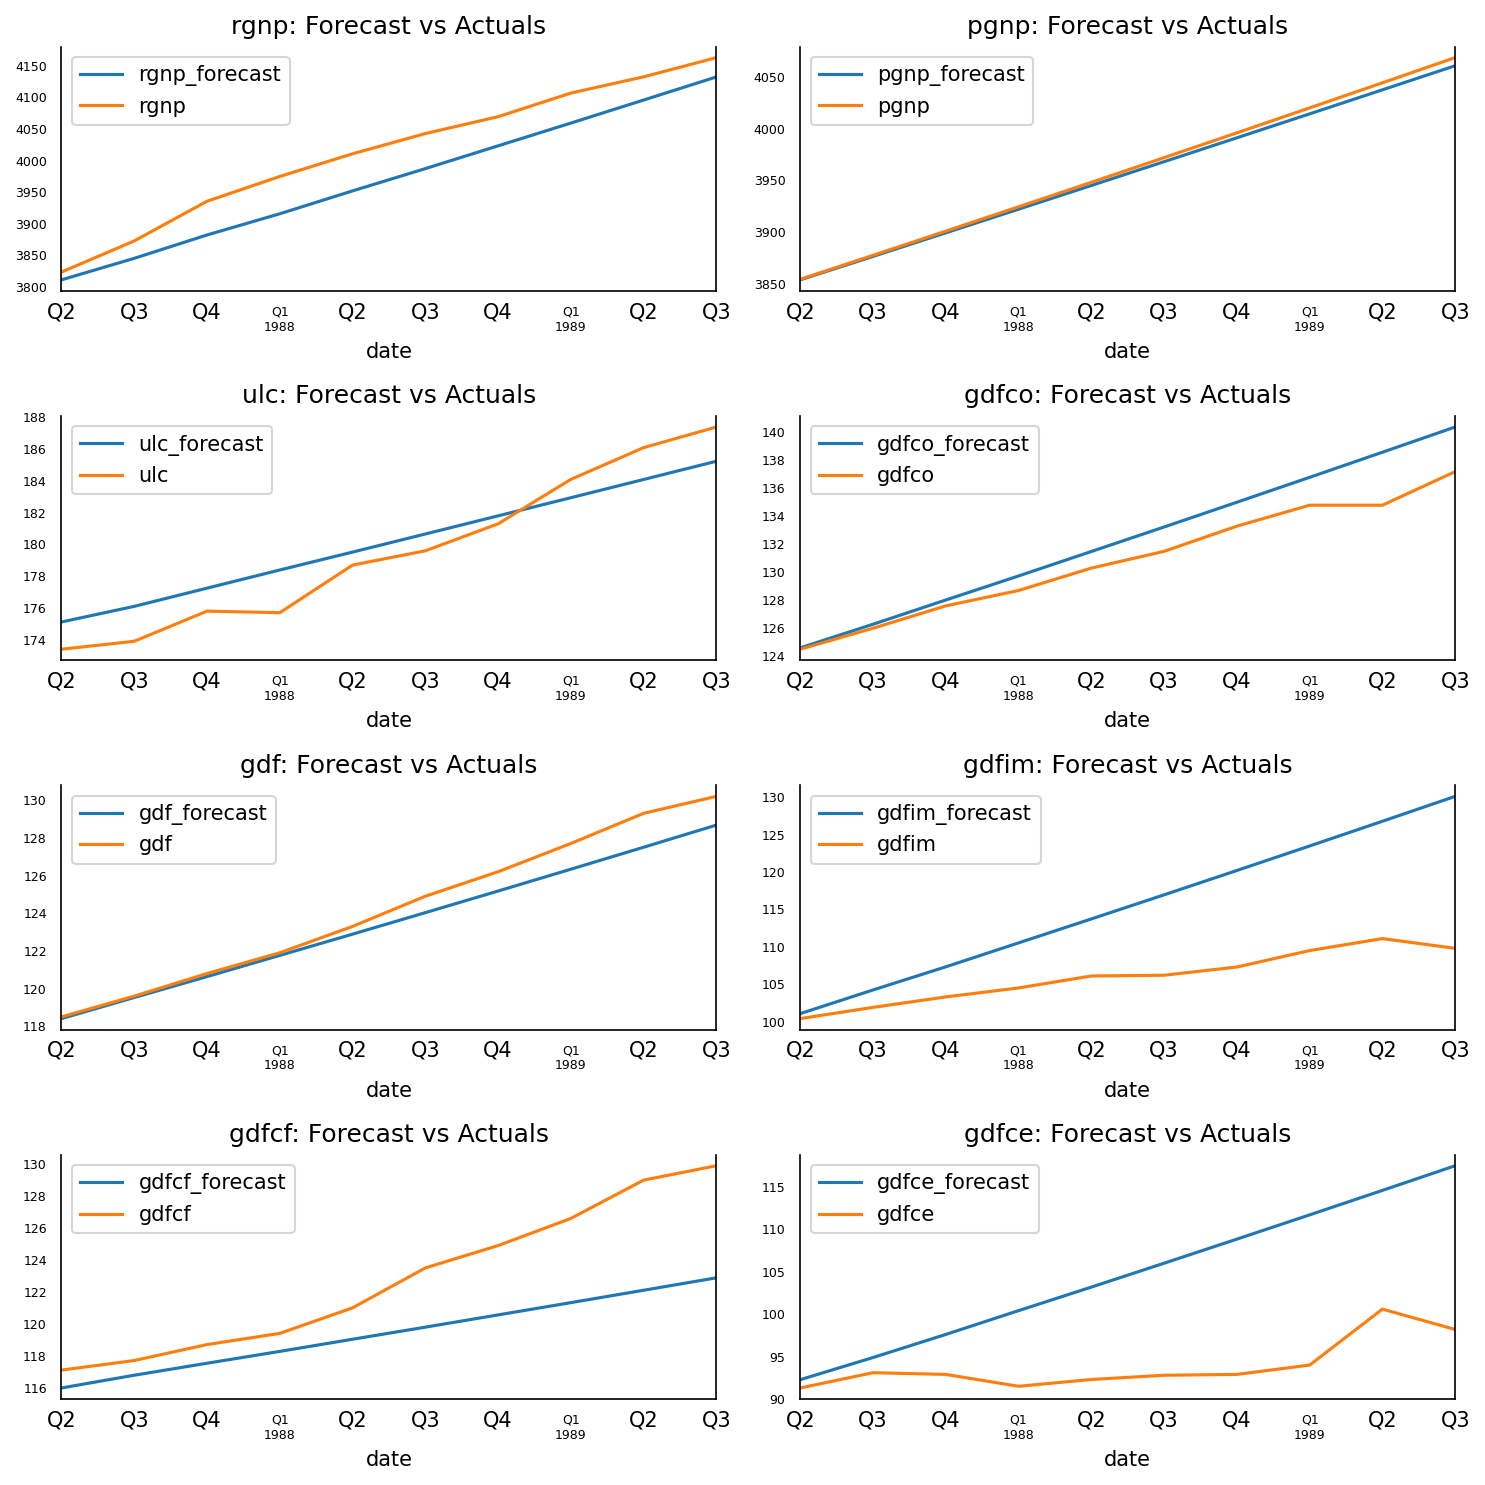

In [126]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_df[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();